### Model Evaluation -- Algorithm Comparison (Nested Cross-Validation) with StratifiedKFold


In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import make_gaussian_quantiles

In [4]:
X_1, y_1 = make_gaussian_quantiles(n_samples= 100,
                                 n_features=2,
                                 n_classes=2,
                                 )

# transform the dataset
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X1, y1 = ros.fit_resample(X_1, y_1)



X1 = pd.DataFrame(X1,columns=['x','y'])
y1 = pd.Series(y1)

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,
                                              test_size=0.25,
                                              random_state=1)

In [6]:

model1 = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
model2 = KNeighborsClassifier(n_neighbors=5)
model3 = DecisionTreeClassifier()
model4 = SVC(kernel= "rbf")
model5  = RandomForestClassifier(random_state=1)

In [7]:
# Setting up the parameter grids
opti_param_grid1 = {'n_estimators':[100, 500],
                     'max_depth': [1, 2, 3]}


opti_param_grid2 = {'n_neighbors': list(range(1, 10)),
                     'p': [1, 2]}

opti_param_grid3 = {'max_depth': list(range(1, 10)) + [None],
                    'criterion': ['gini', 'entropy']}

opti_param_grid4 = {'C': [0.01, 0.1, 1, 10, 100],
                    'gamma': [0.01, 0.1, 1, 10, 100]}
               

opti_param_grid5 = {'n_estimators': [10, 100, 500, 1000, 10000]}

In [8]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip(( opti_param_grid1, opti_param_grid2,
                             opti_param_grid3, opti_param_grid4,opti_param_grid5),
                            (model1, model2, model3, model4, model5),
                            ('GBC', 'KNN', 'DTree', 'SVM', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [9]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=-1)
    print('%s | outer ACC %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))

DTree | outer ACC 84.00% +/- 9.98
GBC | outer ACC 92.00% +/- 6.53
KNN | outer ACC 92.00% +/- 6.53
RForest | outer ACC 92.00% +/- 2.67
SVM | outer ACC 96.00% +/- 3.27


In [10]:
gcv_model_select = GridSearchCV(estimator=model4,
                                param_grid=opti_param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=1)

In [11]:
best_model = gcv_model_select.best_estimator_


## We can skip the next step because we set refit=True
## so scikit-learn has already fit the model to the
## whole training set

# best_model.fit(X_train, y_train)


train_acc = accuracy_score(y_true=y_train, y_pred=best_model.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=best_model.predict(X_test))

print('Accuracy %.2f%% (average over k-fold CV test folds)' %
      (100 * gcv_model_select.best_score_))
print('Best Parameters: %s' % gcv_model_select.best_params_)

print('Training Accuracy: %.2f%%' % (100 * train_acc))
print('Test Accuracy: %.2f%%' % (100 * test_acc))

Accuracy 97.33% (average over k-fold CV test folds)
Best Parameters: {'C': 100, 'gamma': 1}
Training Accuracy: 100.00%
Test Accuracy: 88.00%


In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
randomizedscvs = {}
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for pgrid, est, name in zip(( opti_param_grid1, opti_param_grid2,
                             opti_param_grid3, opti_param_grid4, opti_param_grid5),
                            (model1, model2, model3, model4, model5),
                            ('GBC', 'KNN', 'DTree', 'SVM', 'RForest')):
    rcv = RandomizedSearchCV(estimator=est,
                       param_distributions=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True,
                       n_iter=5)
    randomizedscvs[name] = rcv

In [14]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)


for name, rs_est in sorted(randomizedscvs.items()):
    nested_score = cross_val_score(rs_est, 
                                   X=X_train, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=-1)
    print('%s | outer ACC %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))

DTree | outer ACC 92.14% +/- 6.45
GBC | outer ACC 90.71% +/- 8.29
KNN | outer ACC 90.36% +/- 9.01
RForest | outer ACC 94.82% +/- 6.36
SVM | outer ACC 94.64% +/- 6.59


In [15]:
rcv_model_select = RandomizedSearchCV(estimator=model5,
                                param_distributions=opti_param_grid5,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

rcv_model_select.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'n_estimators': [10, 100, 500, 1000,
                                                         10000]},
                   scoring='accuracy', verbose=1)

In [16]:
best_model2 = rcv_model_select.best_estimator_


## We can skip the next step because we set refit=True
## so scikit-learn has already fit the model to the
## whole training set

# best_model2.fit(X_train, y_train)


train_acc2 = accuracy_score(y_true=y_train, y_pred=best_model2.predict(X_train))
test_acc2 = accuracy_score(y_true=y_test, y_pred=best_model2.predict(X_test))

print('Accuracy %.2f%% (average over k-fold CV test folds)' %
      (100 * rcv_model_select.best_score_))
print('Best Parameters: %s' % rcv_model_select.best_params_)

print('Training Accuracy: %.2f%%' % (100 * train_acc2))
print('Test Accuracy: %.2f%%' % (100 * test_acc2))

Accuracy 96.07% (average over k-fold CV test folds)
Best Parameters: {'n_estimators': 500}
Training Accuracy: 100.00%
Test Accuracy: 76.00%


### ROC and AUC For ML Models

In [17]:
%matplotlib inline

In [18]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
from sklearn.metrics import roc_auc_score, roc_curve


In [19]:
model_lr = LogisticRegression().fit(X_train, y_train)
probs_lr = model_lr.predict_proba(X_test)[:, 1]

model_dt = DecisionTreeClassifier().fit(X_train, y_train)
probs_dt = model_dt.predict_proba(X_test)[:, 1]

model_rf = RandomForestClassifier().fit(X_train, y_train)
probs_rf = model_rf.predict_proba(X_test)[:, 1]

model_gb =  GradientBoostingClassifier().fit(X_train, y_train)
probs_gb = model_gb.predict_proba(X_test)[:, 1]

model_KNN =  KNeighborsClassifier().fit(X_train, y_train)
probs_KNN = model_KNN.predict_proba(X_test)[:, 1]

model = SVC(probability=True)
model_SVC = model.fit(X_train, y_train)
probs_SVC = model_SVC.predict_proba(X_test)[:, 1]

In [20]:
y_test_int = y_test.replace({'Good': 1, 'Bad': 0})
auc_lr = roc_auc_score(y_test_int, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_int, probs_lr)


In [21]:
auc_dt = roc_auc_score(y_test_int, probs_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_int, probs_dt)


In [22]:
auc_rf = roc_auc_score(y_test_int, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_int, probs_rf)


In [24]:
auc_gb = roc_auc_score(y_test_int, probs_gb)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test_int, probs_gb)


In [25]:
auc_KNN = roc_auc_score(y_test_int, probs_KNN)
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test_int, probs_KNN)


In [26]:
auc_SVC = roc_auc_score(y_test_int, probs_SVC)
fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(y_test_int, probs_SVC)

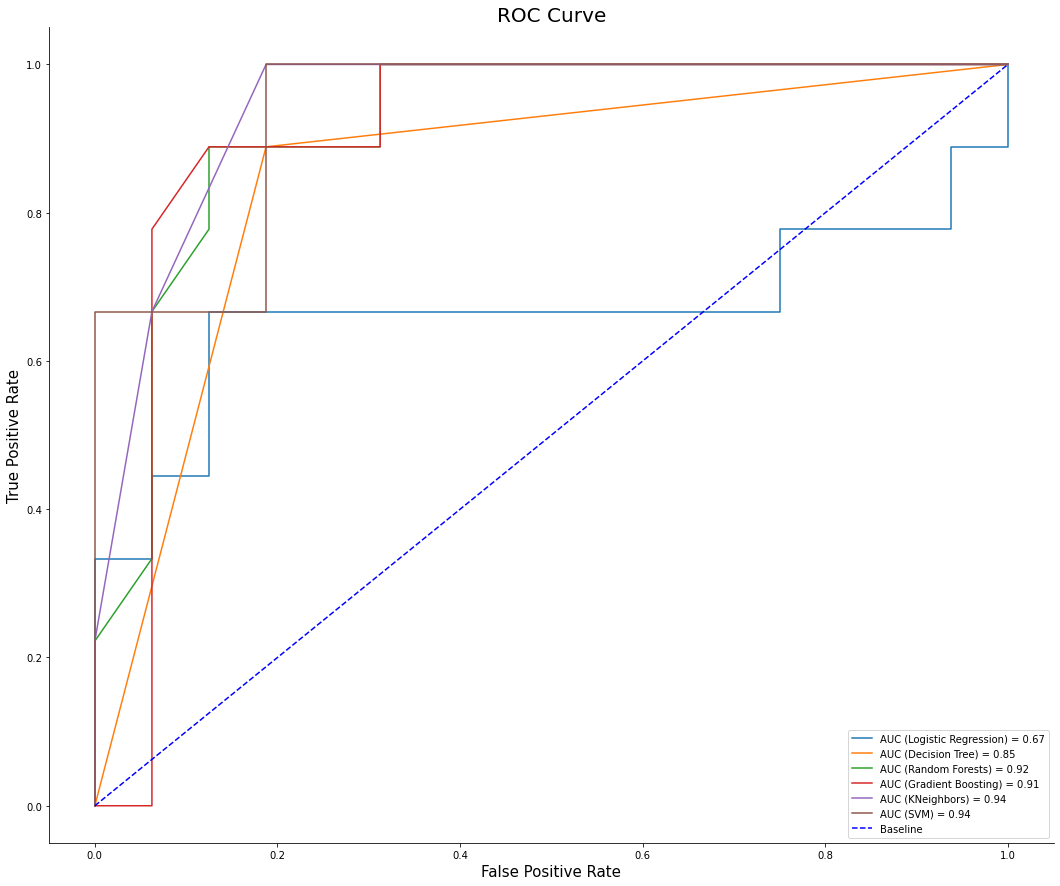

In [27]:

plt.figure(figsize=(18, 15))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decision Tree) = {auc_dt:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.plot(fpr_gb, tpr_gb, label=f'AUC (Gradient Boosting) = {auc_gb:.2f}')
plt.plot(fpr_KNN, tpr_KNN, label=f'AUC (KNeighbors) = {auc_KNN:.2f}')
plt.plot(fpr_SVC, tpr_SVC, label=f'AUC (SVM) = {auc_SVC:.2f}')


plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.legend()